## FBRef - Progressive Passing for Top 5 Leagues

Import libraries and define functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import warnings
warnings.filterwarnings('ignore')

In [4]:
def fbref_player_stats(url):
    
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import re
    
    response = requests.get(url)
    print(response)
    
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", response.text), 'lxml')
    
    player_table = soup.find_all('table')[1]
    
    player_df = pd.read_html(str(player_table))[0]
    
    level_one = player_df.columns.get_level_values(0).astype(str)
    level_two = player_df.columns.get_level_values(1).astype(str)
    new_columns = level_one + "|" + level_two
    new_columns = [x.split("|")[1] if x[0:7] == 'Unnamed' else x for x in new_columns]
    new_columns
    player_df.columns = new_columns
    
    drop_indices = player_df[player_df['Player'] == 'Player'].index
    player_df.drop(drop_indices, inplace = True)
    
    return player_df

Access data and convert columns to numeric.

In [5]:
passing = fbref_player_stats("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats")
num_columns = ['Age','90s',
               'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|TotDist', 'Total|PrgDist', 
               'Short|Cmp', 'Short|Att', 'Short|Cmp%', 
               'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 
               'Long|Cmp', 'Long|Att', 'Long|Cmp%', 
               'Ast', 'xA', 'A-xA', 'KP', 
               '1/3', 'PPA', 'CrsPA', 'Prog']
passing[num_columns] = passing[num_columns].apply(pd.to_numeric)
passing.drop('Matches', axis=1, inplace=True)
passing.head()

<Response [200]>


Rk               Player   Nation    Pos           Squad                Comp  \
0  1  Patrick van Aanholt   nl NED     DF  Crystal Palace  eng Premier League   
1  2           Max Aarons  eng ENG     DF    Norwich City  eng Premier League   
2  3     Yunis Abdelhamid   ma MAR     DF           Reims          fr Ligue 1   
3  4   Suleiman Abdullahi   ng NGA  FW,MF    Union Berlin       de Bundesliga   
4  5          Mehdi Abeid   dz ALG     MF          Nantes          fr Ligue 1   

    Age  Born   90s  Total|Cmp  ...  Long|Att  Long|Cmp%  Ast   xA  A-xA  \
0  28.0  1990  21.0      934.0  ...     263.0       59.3    0  1.8  -1.8   
1  19.0  2000  27.0     1005.0  ...     203.0       51.7    1  3.5  -2.5   
2  31.0  1987  28.0     1328.0  ...     568.0       82.4    0  0.2  -0.2   
3  22.0  1996   1.1       11.0  ...       3.0       33.3    0  0.0   0.0   
4  26.0  1992  20.2      801.0  ...     250.0       65.2    2  1.4   0.6   

     KP   1/3   PPA  CrsPA   Prog  
0  24.0  67.0  20.0    4.0  158.0  
1  20.0  36.0  26.0   11.0  105.0  
2   2.0  45.0   3.0    0.0   83.0  
3   0.0   1.0   1.0    1.0    3.0  
4  26.0  85.0   6.0    4.0   82.0  

[5 rows x 31 columns]

### Filter Passing

Define function to filter the fbref data by various fields

In [6]:
def player_filter_fbref(dataframe, 
                        mins_filter = 10, 
                        age_min = 0, 
                        age_max = 35, 
                        position_filter = [], 
                        nation_filter = [], 
                        squad_filter = [], 
                        comp_filter = []):
    
    filtered_df = dataframe.copy()
    
    if len(str(mins_filter)) > 0:
        filtered_df = filtered_df[filtered_df['90s'] > mins_filter]
    if len(str(age_min)) > 0:
        filtered_df = filtered_df[filtered_df['Age'] > age_min]
    if len(str(age_max)) > 0:
        filtered_df = filtered_df[filtered_df['Age'] < age_max]
    if len(position_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Pos'].isin(position_filter))]
    if len(nation_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Nation'].isin(nation_filter))]
    if len(squad_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Squad'].isin(squad_filter))]
    if len(comp_filter) > 0:
        filtered_df = filtered_df[(filtered_df['Comp'].isin(comp_filter))]
        
    return filtered_df

In [7]:
passing_filtered = player_filter_fbref(passing,
                                       mins_filter = 20,
                                       age_min = 0,
                                       age_max = 35,
                                       position_filter = [],
                                       nation_filter = [],
                                       squad_filter = [],
                                       comp_filter = [])

### Passing per 90s

In [8]:
pass_cols =  ['Total|Cmp', 'Total|Att', 'Total|Cmp%', 
                'Total|TotDist', 'Total|PrgDist', 
                'Short|Cmp', 'Short|Att', 'Short|Cmp%', 
                'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 
                'Long|Cmp', 'Long|Att', 'Long|Cmp%', 
                'Ast', 'xA', 'A-xA', 'KP', 
                '1/3', 'PPA', 'CrsPA', 'Prog']

for col in pass_cols:
    passing_filtered[col + '|90'] = passing_filtered[col] / passing_filtered['90s']

passing_filtered.head()

Rk               Player   Nation Pos           Squad                Comp  \
0  1  Patrick van Aanholt   nl NED  DF  Crystal Palace  eng Premier League   
1  2           Max Aarons  eng ENG  DF    Norwich City  eng Premier League   
2  3     Yunis Abdelhamid   ma MAR  DF           Reims          fr Ligue 1   
4  5          Mehdi Abeid   dz ALG  MF          Nantes          fr Ligue 1   
7  8        Tammy Abraham  eng ENG  FW         Chelsea  eng Premier League   

    Age  Born   90s  Total|Cmp  ...  Long|Att|90  Long|Cmp%|90    Ast|90  \
0  28.0  1990  21.0      934.0  ...    12.523810      2.823810  0.000000   
1  19.0  2000  27.0     1005.0  ...     7.518519      1.914815  0.037037   
2  31.0  1987  28.0     1328.0  ...    20.285714      2.942857  0.000000   
4  26.0  1992  20.2      801.0  ...    12.376238      3.227723  0.099010   
7  21.0  1997  21.5      250.0  ...     2.139535      3.437209  0.139535   

      xA|90   A-xA|90     KP|90    1/3|90    PPA|90  CrsPA|90   Prog|90  
0  0.085714 -0.085714  1.142857  3.190476  0.952381  0.190476  7.523810  
1  0.129630 -0.092593  0.740741  1.333333  0.962963  0.407407  3.888889  
2  0.007143 -0.007143  0.071429  1.607143  0.107143  0.000000  2.964286  
4  0.069307  0.029703  1.287129  4.207921  0.297030  0.198020  4.059406  
7  0.106977  0.032558  0.790698  0.744186  0.232558  0.000000  1.488372  

[5 rows x 53 columns]

### Normalised Passing

In [9]:
pass_cols =  [
    'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|Cmp|90', 'Total|Att|90', 'Total|Cmp%|90',
    'Total|TotDist', 'Total|PrgDist', 'Total|TotDist|90', 'Total|PrgDist|90', 
    'Short|Cmp', 'Short|Att', 'Short|Cmp%', 'Short|Cmp|90', 'Short|Att|90', 'Short|Cmp%|90', 
    'Medium|Cmp','Medium|Att', 'Medium|Cmp%', 'Medium|Cmp|90','Medium|Att|90', 'Medium|Cmp%|90', 
    'Long|Cmp', 'Long|Att', 'Long|Cmp%', 'Long|Cmp|90', 'Long|Att|90', 'Long|Cmp%|90', 
    'Ast', 'xA', 'A-xA', 'KP', 'Ast|90', 'xA|90', 'A-xA|90', 'KP|90', 
    '1/3', 'PPA', 'CrsPA', 'Prog', '1/3|90', 'PPA|90', 'CrsPA|90', 'Prog|90',
]

for col in pass_cols:
    max_col = passing_filtered[col].max()
    min_col = passing_filtered[col].min()
    scale_col = (passing_filtered[col] - min_col) / (max_col - min_col)
    passing_filtered[col + '|N'] = scale_col

passing_filtered.head()

Rk               Player   Nation Pos           Squad                Comp  \
0  1  Patrick van Aanholt   nl NED  DF  Crystal Palace  eng Premier League   
1  2           Max Aarons  eng ENG  DF    Norwich City  eng Premier League   
2  3     Yunis Abdelhamid   ma MAR  DF           Reims          fr Ligue 1   
4  5          Mehdi Abeid   dz ALG  MF          Nantes          fr Ligue 1   
7  8        Tammy Abraham  eng ENG  FW         Chelsea  eng Premier League   

    Age  Born   90s  Total|Cmp  ...  A-xA|90|N   KP|90|N     1/3|N     PPA|N  \
0  28.0  1990  21.0      934.0  ...   0.263755  0.277922  0.228374  0.217391   
1  19.0  2000  27.0     1005.0  ...   0.252264  0.180135  0.121107  0.282609   
2  31.0  1987  28.0     1328.0  ...   0.395021  0.017370  0.152249  0.032609   
4  26.0  1992  20.2      801.0  ...   0.456577  0.313006  0.290657  0.065217   
7  21.0  1997  21.5      250.0  ...   0.461347  0.192283  0.051903  0.054348   

   CrsPA|N    Prog|N  1/3|90|N  PPA|90|N  CrsPA|90|N  Prog|90|N  
0    0.100  0.434066  0.293423  0.232339    0.150916   0.584956  
1    0.275  0.288462  0.120541  0.234921    0.322792   0.302350  
2    0.000  0.228022  0.146030  0.026138    0.000000   0.230465  
4    0.100  0.225275  0.388138  0.072462    0.156893   0.315608  
7    0.000  0.087912  0.065696  0.056734    0.000000   0.115717  

[5 rows x 97 columns]

## Exploration

Convert from wide to long data to create Swarm Plots

In [10]:
value_cols = [
        'Total|Cmp', 'Total|Att', 'Total|Cmp%', 'Total|TotDist',
        'Total|PrgDist', 'Short|Cmp', 'Short|Att', 'Short|Cmp%', 'Medium|Cmp',
        'Medium|Att', 'Medium|Cmp%', 'Long|Cmp', 'Long|Att', 'Long|Cmp%', 'Ast',
        'xA', 'A-xA', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog',
        'Total|Cmp|90', 'Total|Att|90', 'Total|Cmp%|90', 'Total|TotDist|90',
        'Total|PrgDist|90', 'Short|Cmp|90', 'Short|Att|90', 'Short|Cmp%|90',
        'Medium|Cmp|90', 'Medium|Att|90', 'Medium|Cmp%|90', 'Long|Cmp|90',
        'Long|Att|90', 'Long|Cmp%|90', 'Ast|90', 'xA|90', 'A-xA|90', 'KP|90',
        '1/3|90', 'PPA|90', 'CrsPA|90', 'Prog|90', 'Total|Cmp|N', 'Total|Att|N',
        'Total|Cmp%|N', 'Total|Cmp|90|N', 'Total|Att|90|N', 'Total|Cmp%|90|N',
        'Total|TotDist|N', 'Total|PrgDist|N', 'Total|TotDist|90|N',
        'Total|PrgDist|90|N', 'Short|Cmp|N', 'Short|Att|N', 'Short|Cmp%|N',
        'Short|Cmp|90|N', 'Short|Att|90|N', 'Short|Cmp%|90|N', 'Medium|Cmp|N',
        'Medium|Att|N', 'Medium|Cmp%|N', 'Medium|Cmp|90|N', 'Medium|Att|90|N',
        'Medium|Cmp%|90|N', 'Long|Cmp|N', 'Long|Att|N', 'Long|Cmp%|N',
        'Long|Cmp|90|N', 'Long|Att|90|N', 'Long|Cmp%|90|N', 'Ast|N', 'xA|N',
        'A-xA|N', 'KP|N', 'Ast|90|N', 'xA|90|N', 'A-xA|90|N', 'KP|90|N',
        '1/3|N', 'PPA|N', 'CrsPA|N', 'Prog|N', '1/3|90|N', 'PPA|90|N',
        'CrsPA|90|N', 'Prog|90|N']

passing_long = pd.melt(passing_filtered,
                       id_vars=['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp'],
                       value_vars=value_cols)
passing_long['value'] = passing_long['value'].apply(pd.to_numeric)


### Filtered Swarm Plots

Define function to create swarm plots for specified columns

In [11]:
def passing_swarm(dataframe, columns = []):

    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]
    
    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')
    plt.figure(figsize=(15,7.5))
    g1 = sns.swarmplot(x="value", y="variable", data=dataframe,
                      palette='pastel',
                      alpha = 0.5)

    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle('Title Placeholder',
                 fontproperties = font, x = 0.2, y = 0.95)
    plt.title('Progressive Passing Percentiles',
              fontproperties = font, size=10, loc='left')
    plt.show()

#### Passing per 90s

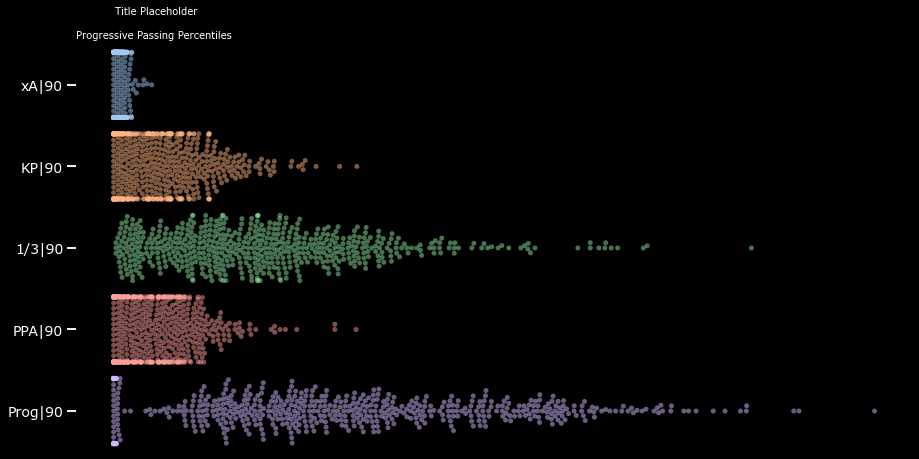

In [12]:
passing_swarm(passing_long, columns=['Prog|90', 'KP|90', '1/3|90', 'PPA|90', 'xA|90'])

#### Passing Normalised

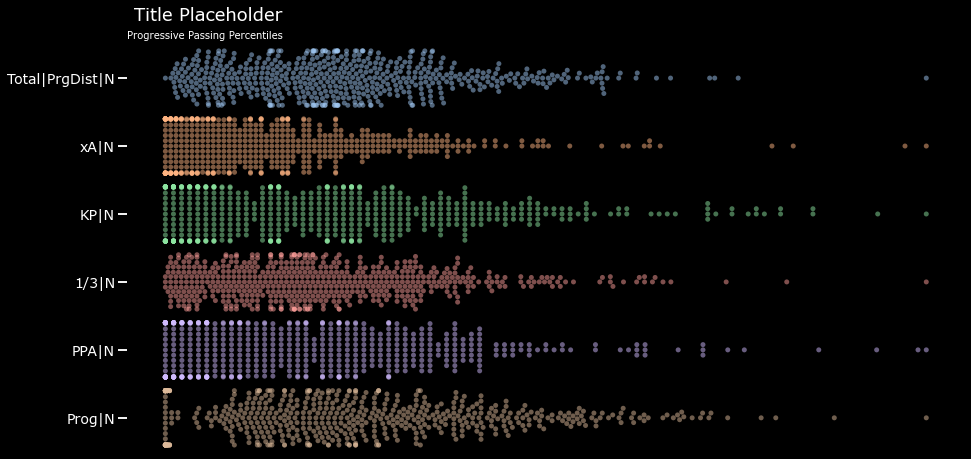

In [13]:
passing_swarm(passing_long, columns=['Total|PrgDist|N', 'Prog|N', 'KP|N', '1/3|N', 'PPA|N', 'xA|N'])

#### Passing per 90s + Normalised

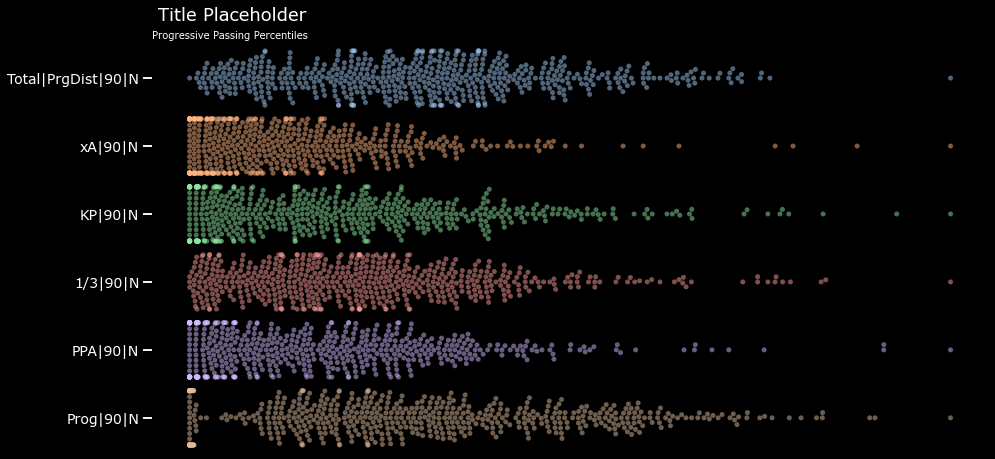

In [14]:
passing_swarm(passing_long, columns=['Total|PrgDist|90|N', 'Prog|90|N', 'KP|90|N', '1/3|90|N', 'PPA|90|N', 'xA|90|N'])

### Player Swarm Plots

Define swarm plots for specific players and team colours

In [15]:
def passing_swarm_player(dataframe, selected_player, columns = [], team_primary_colour='w', team_secondary_colour='w', title_ha = 0.2):

    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]
        
    dataframe_player = dataframe[dataframe['Player'] == selected_player]

    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')
    plt.figure(figsize=(15,7.5))
    g1 = sns.swarmplot(x="value", y="variable", data=dataframe,
                       order = columns,
                       palette='pastel',
                       alpha = 0.2)
    g2 = sns.swarmplot(x="value", y="variable", data=dataframe_player,
                       order = columns,
                       alpha = 0.9, size = 10, 
                       color=team_primary_colour, edgecolor = team_secondary_colour, linewidth=1)


    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle(selected_player,
                 fontproperties = font, x = title_ha, y = 0.95)
    plt.title('Title Placeholder',
              fontproperties = font, size=10, loc='left')
    plt.show()

#### All Players (20+ 90s)

Top performers across normalised per 90 minutes:

In [16]:
columns=['Total|PrgDist|90|N', 'Prog|90|N', 'KP|90|N', '1/3|90|N', 'PPA|90|N', 'xA|90|N']
passing_long[passing_long['variable'].isin(columns) & 
             (passing_long['Pos'] != 'GK') &
             (passing_long['value'] > 0.8)].sort_values('value', ascending=False)

Rk                  Player   Nation    Pos            Squad  \
49616   642          Ángel Di María   ar ARG  FW,MF        Paris S-G   
44960   642          Ángel Di María   ar ARG  FW,MF        Paris S-G   
46391  1820           Dimitri Payet   fr FRA     FW        Marseille   
48898    42             David Alaba   at AUT     DF    Bayern Munich   
50649    59  Trent Alexander-Arnold  eng ENG     DF        Liverpool   
46116   603         Kevin De Bruyne   be BEL     MF  Manchester City   
49608   603         Kevin De Bruyne   be BEL     MF  Manchester City   
49823  1574            Lionel Messi   ar ARG     FW        Barcelona   
50772   603         Kevin De Bruyne   be BEL     MF  Manchester City   
51149  2295           Damián Suárez   uy URU     DF           Getafe   
44952   603         Kevin De Bruyne   be BEL     MF  Manchester City   
48932   178             Éver Banega   ar ARG     MF          Sevilla   
46124   642          Ángel Di María   ar ARG  FW,MF        Paris S-G   
50678   178             Éver Banega   ar ARG     MF          Sevilla   
50987  1574            Lionel Messi   ar ARG     FW        Barcelona   
49465  2578         Piotr Zieliński   pl POL     MF           Napoli   
50913  1216          Joshua Kimmich   de GER  MF,DF    Bayern Munich   
50645    46            Luis Alberto   es ESP     MF            Lazio   

                     Comp   variable     value  
49616          fr Ligue 1   PPA|90|N  1.000000  
44960          fr Ligue 1    xA|90|N  1.000000  
46391          fr Ligue 1    KP|90|N  1.000000  
48898       de Bundesliga   1/3|90|N  1.000000  
50649  eng Premier League  Prog|90|N  1.000000  
46116  eng Premier League    KP|90|N  0.929231  
49608  eng Premier League   PPA|90|N  0.912356  
49823          es La Liga   PPA|90|N  0.912183  
50772  eng Premier League  Prog|90|N  0.900730  
51149          es La Liga  Prog|90|N  0.893761  
44952  eng Premier League    xA|90|N  0.877196  
48932          es La Liga   1/3|90|N  0.835976  
46124          fr Ligue 1    KP|90|N  0.832514  
50678          es La Liga  Prog|90|N  0.831968  
50987          es La Liga  Prog|90|N  0.831558  
49465          it Serie A   1/3|90|N  0.829952  
50913       de Bundesliga  Prog|90|N  0.823812  
50645          it Serie A  Prog|90|N  0.803497

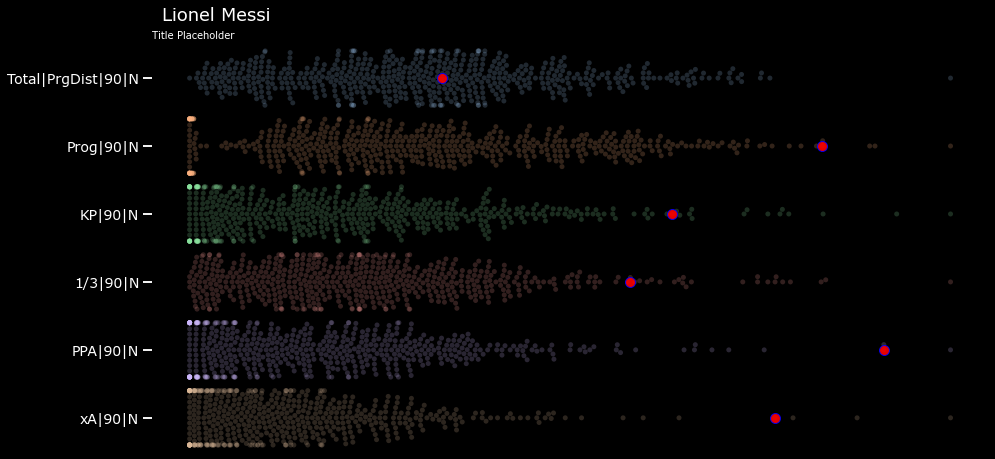

In [17]:
passing_swarm_player(passing_long, 'Lionel Messi', columns=columns, team_primary_colour='r', team_secondary_colour='b', title_ha=0.185)

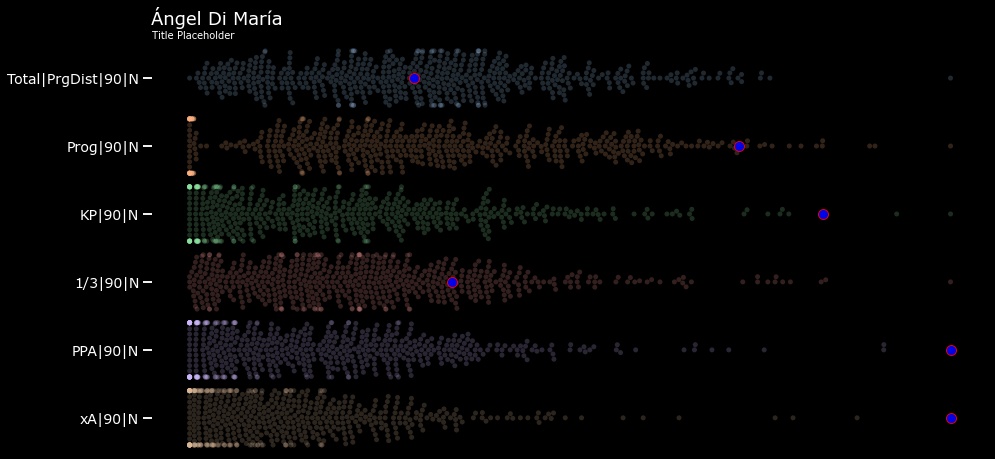

In [18]:
passing_swarm_player(passing_long, 'Ángel Di María', columns=columns, team_primary_colour='b', team_secondary_colour='r', title_ha=0.185)

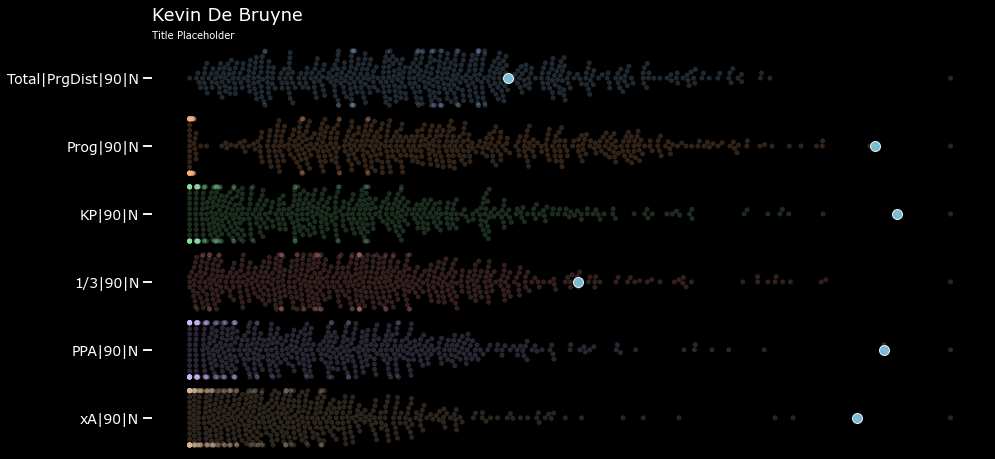

In [19]:
passing_swarm_player(passing_long, 'Kevin De Bruyne', columns=columns, team_primary_colour='skyblue', team_secondary_colour='w', title_ha=0.195)

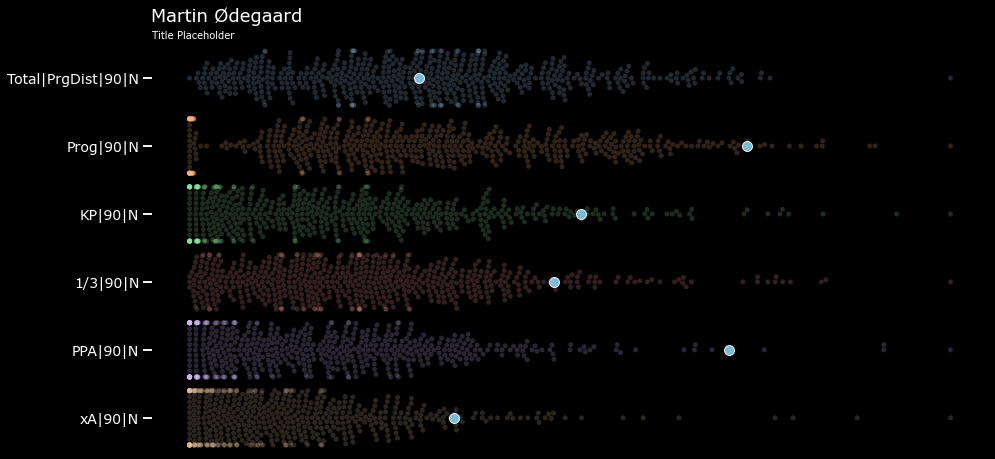

In [20]:
passing_swarm_player(passing_long, 'Martin Ødegaard', columns=columns, team_primary_colour='skyblue', team_secondary_colour='w', title_ha=0.195)

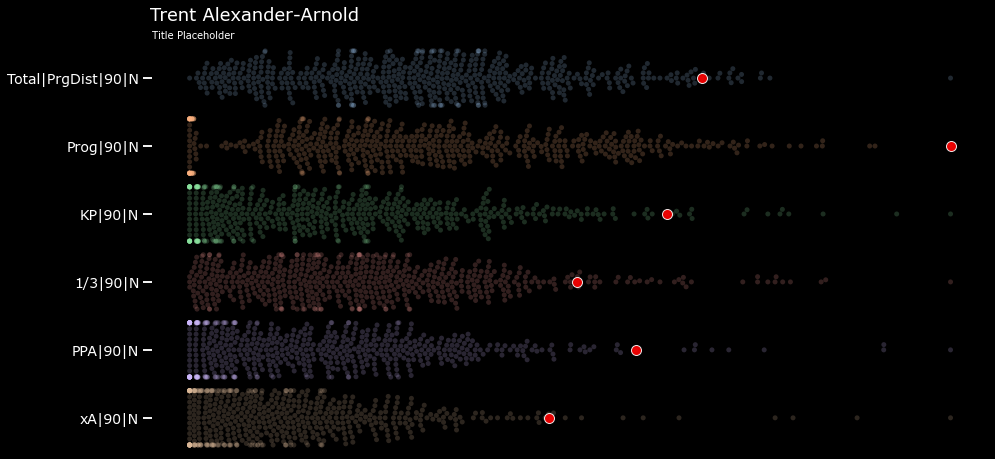

In [21]:
passing_swarm_player(passing_long, 'Trent Alexander-Arnold', columns=columns, team_primary_colour='r', team_secondary_colour='w', title_ha=0.22)

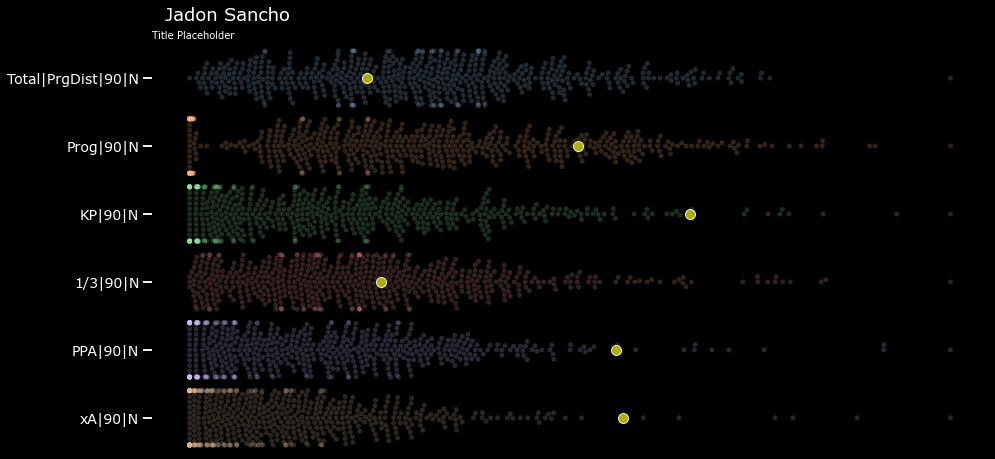

In [22]:
passing_swarm_player(passing_long, 'Jadon Sancho', columns=columns, team_primary_colour='y', team_secondary_colour='w', title_ha=0.195)

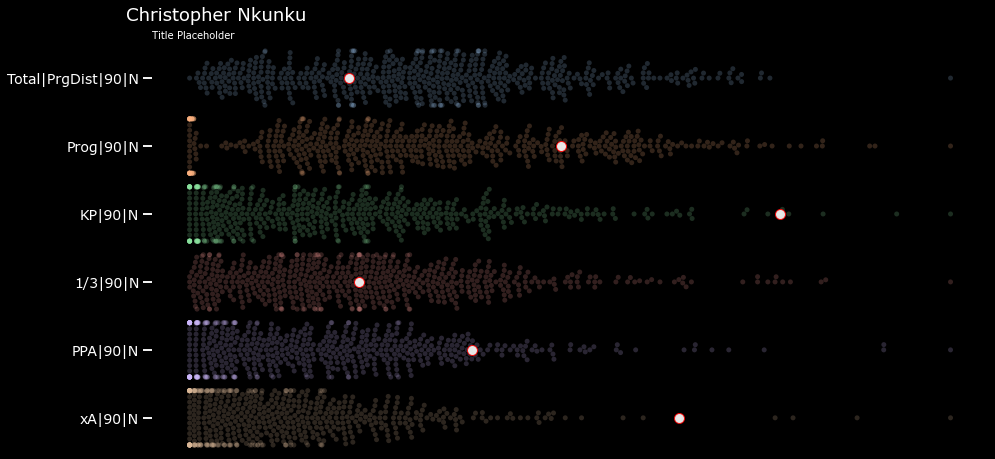

In [23]:
passing_swarm_player(passing_long, 'Christopher Nkunku', columns=columns, team_primary_colour='w', team_secondary_colour='r', title_ha=0.185)

## Custom Plots

### Leaders

Define function to include images to plots and add custom title

In [24]:
def custom_image_player_swarms(dataframe,
                               selected_player,
                               image_path,
                               columns,
                               title = 'Placeholder',
                               title_ha = 0.17
                              ):
    # Keep only relevant columns
    if len(columns) > 0:
        dataframe = dataframe[dataframe['variable'].isin(columns)]

    # Keep only specified player
    dataframe_player = dataframe[dataframe['Player'] == selected_player]
    dataframe_player = dataframe_player.set_index('variable').reindex(columns).reset_index()

    # Set plot themes
    plt.style.use("dark_background")
    font = font_manager.FontProperties(fname='C:/Windows/Fonts/verdana.ttf')
    sns.set_style({"axes.spines.left":False, "axes.spines.bottom":False, "axes.spines.right":False, "axes.spines.top":False,
                  "axes.grid":False})
    sns.set_context('talk')

    # Set up figure
    plt.figure(figsize=(15,7.5))
    
    # Plot swarm for all
    swarm = sns.swarmplot(x="value", y="variable", data=dataframe,
                          order = columns,
                          palette='pastel',
                          alpha = 0.2)
    
    # Plot custom image for player
    player = sns.scatterplot(x="value", y="variable", data=dataframe_player)
    image = OffsetImage(plt.imread(image_path, 0), zoom=0.2)
    x = dataframe_player['value']
    y = dataframe_player['variable']
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(image, (x0, y0), frameon=False)
        player.add_artist(ab)

    # Set plot labels and titles
    plt.xlabel('')
    plt.xticks([0, 0.5, 1], size = 11)
    plt.ylabel('')
    plt.yticks(fontproperties = font, size = 14)
    plt.suptitle(title, fontproperties = font, size = 18 , x = 0.125, y = 0.99, ha='left')
    plt.title('2019/20 - Progressive Passes from fbref.com - Normalised and per 90 mins - @TLMAnalytics',
              fontproperties = font, size=10, loc='left')

    plt.show()

#### Lionel Messi

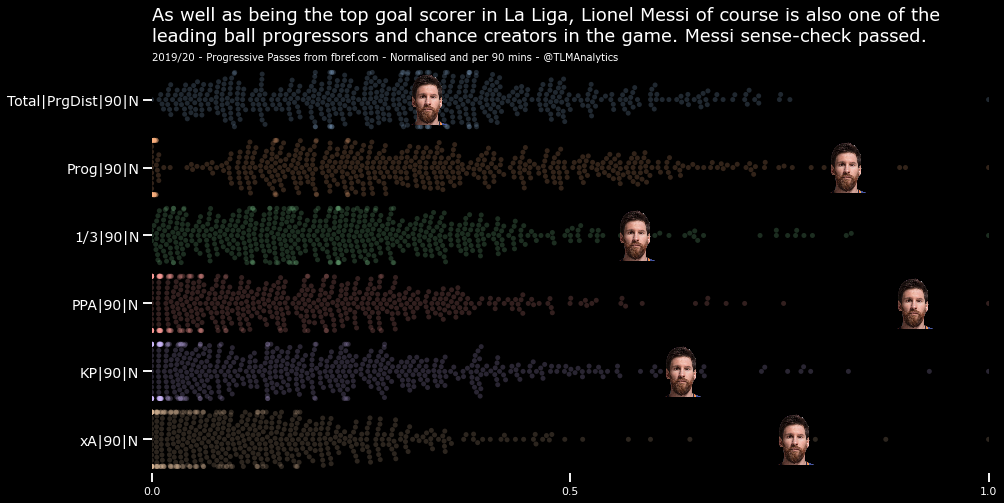

In [25]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Lionel Messi',
                           image_path = "messi.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'As well as being the top goal scorer in La Liga, Lionel Messi of course is also one of the \nleading ball progressors and chance creators in the game. Messi sense-check passed.',
                           title_ha = 0.17
                           )

#### Angel Di Maria

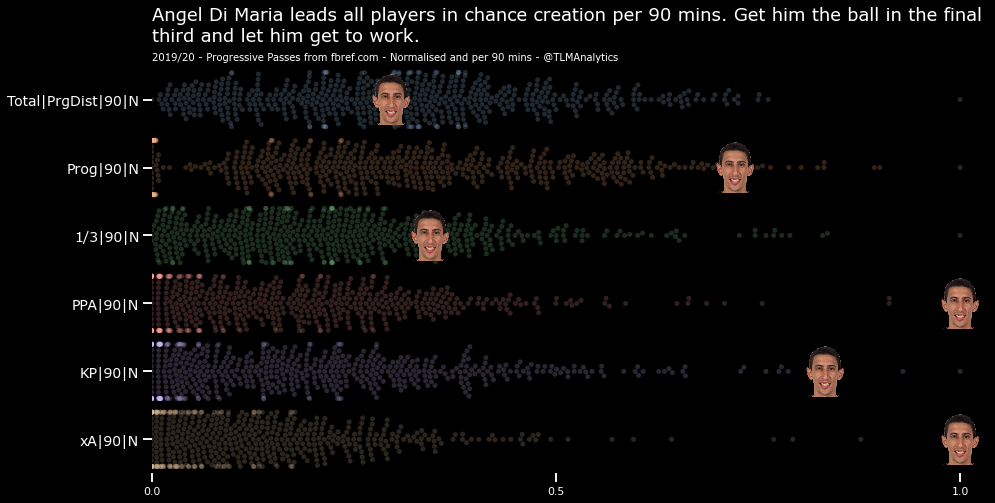

In [32]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Ángel Di María',
                           image_path = "adm.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'Angel Di Maria leads all players in chance creation per 90 mins. Get him the ball in the final\nthird and let him get to work.',
                           title_ha = 0.17
                           )

#### Kevin De Bruyne

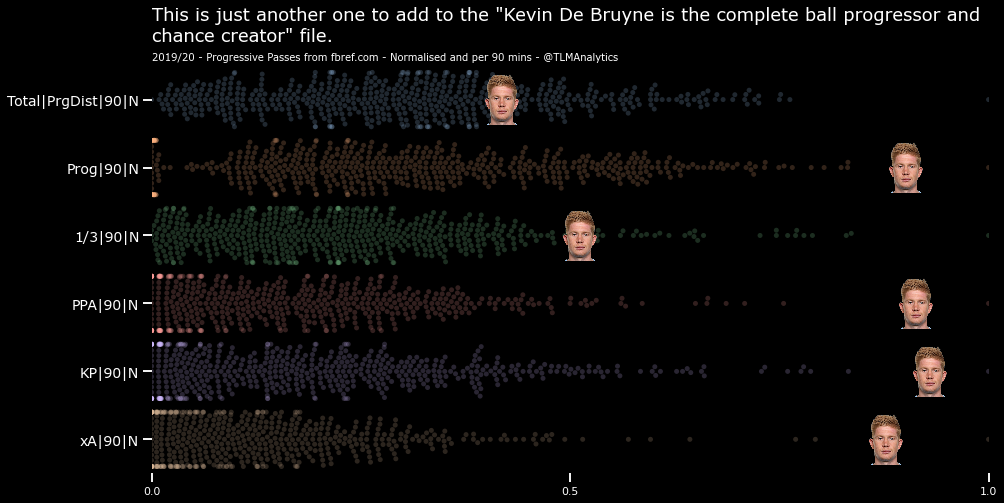

In [31]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Kevin De Bruyne',
                           image_path = "kdb.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'This is just another one to add to the "Kevin De Bruyne is the complete ball progressor and\nchance creator" file.',
                           title_ha = 0.17
                           )

#### David Alaba

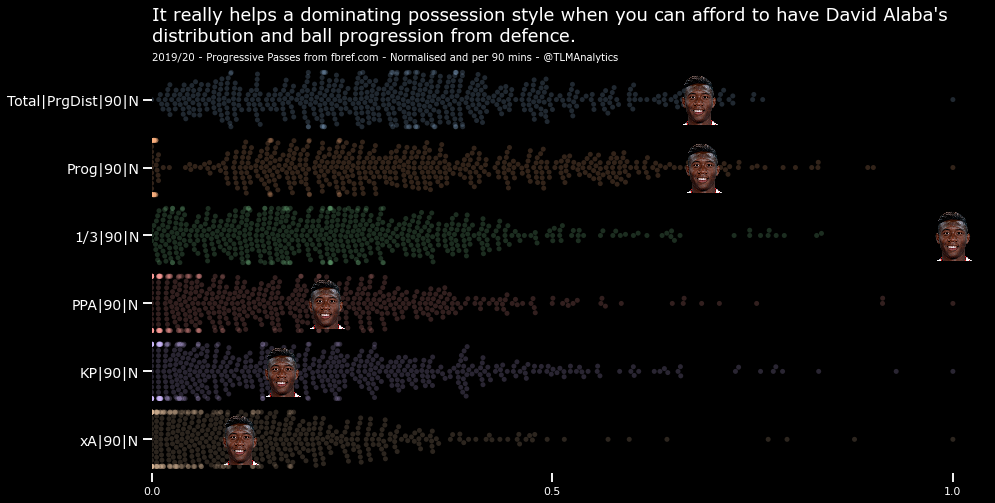

In [30]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'David Alaba',
                           image_path = "alaba.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'It really helps a dominating possession style when you can afford to have David Alaba\'s\ndistribution and ball progression from defence.',
                           title_ha = 0.17
                           )

### u23s

#### Trent Alexander-Arnold

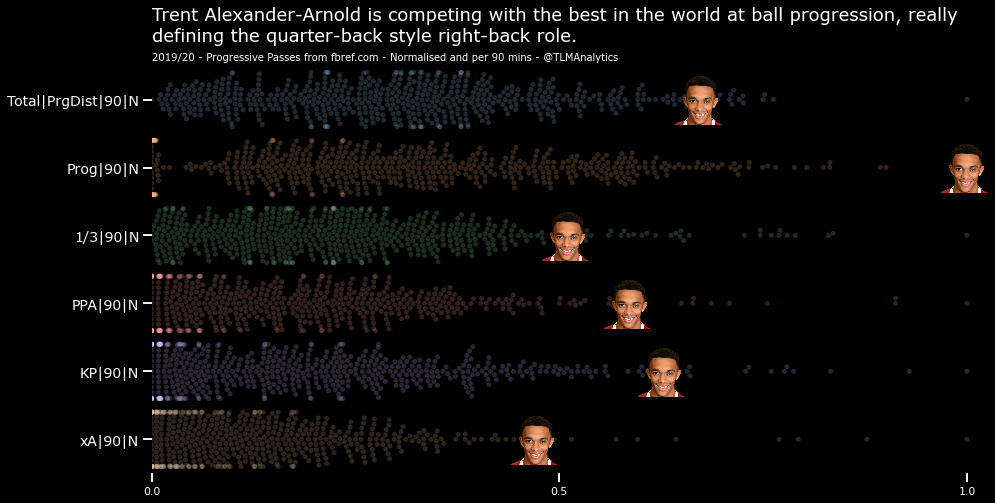

In [29]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Trent Alexander-Arnold',
                           image_path = "taa.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'Trent Alexander-Arnold is competing with the best in the world at ball progression, really\ndefining the quarter-back style right-back role.',
                           title_ha = 0.17
                           )

#### Martin Odegaard

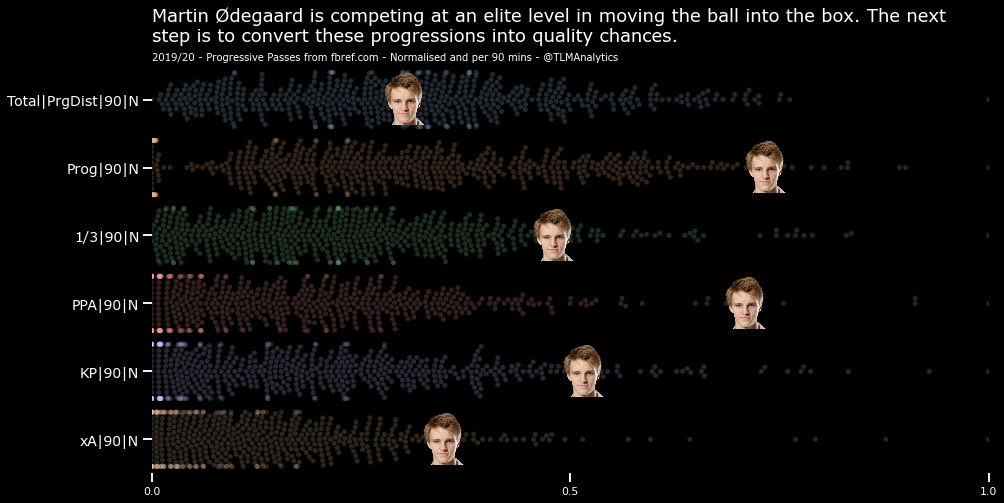

In [28]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Martin Ødegaard',
                           image_path = "odegaard.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'Martin Ødegaard is competing at an elite level in moving the ball into the box. The next\nstep is to convert these progressions into quality chances.',
                           title_ha = 0.17
                           )

#### Jadon Sancho

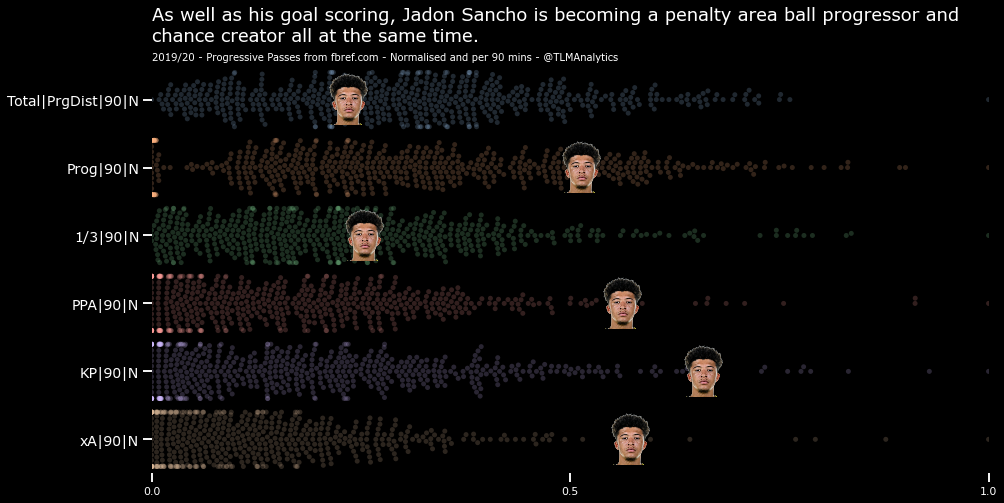

In [27]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Jadon Sancho',
                           image_path = "sancho.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'As well as his goal scoring, Jadon Sancho is becoming a penalty area ball progressor and\nchance creator all at the same time.',
                           title_ha = 0.17
                           )

#### Christopher Nkunku

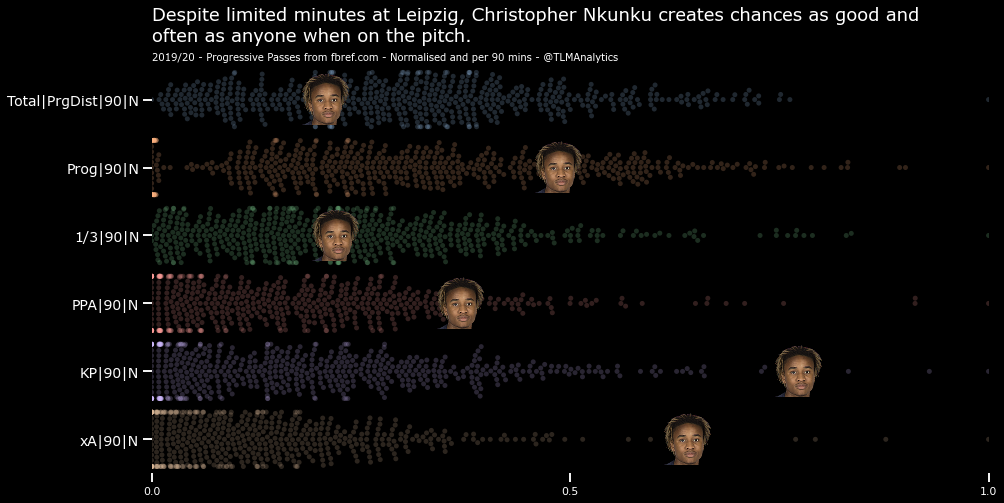

In [26]:
custom_image_player_swarms(dataframe = passing_long,
                           selected_player = 'Christopher Nkunku',
                           image_path = "nkunku.png",
                           columns = ['Total|PrgDist|90|N', 'Prog|90|N', '1/3|90|N', 'PPA|90|N', 'KP|90|N', 'xA|90|N'],
                           title = 'Despite limited minutes at Leipzig, Christopher Nkunku creates chances as good and\noften as anyone when on the pitch.',
                           title_ha = 0.17
                           )